# Traffic Flow Forecasting

## Objective 

Competition main goal is to **forecast twelve-hours of traffic flow in a major U.S. metropolitan area** and model interactions across a network of roadways, using a time series labelled dataset with both location coordinates and a direction of travel.

Dataset from: https://www.kaggle.com/competitions/tabular-playground-series-mar-2022/overview

## Dataset Descriptions
`train.csv` : the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991. 
- row_id: a unique identifier for this instance 
- time: the 20-minute period in which each measurement was taken 
- x: the east-west midpoint coordinate of the roadway 
- y: the north-south midpoint coordinate of the roadway 
- direction: the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel congestion 
- congestion: levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.
`test.csv` : the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.

`sample_submission.csv` : a sample submission file in the correct format.

In [1]:
#!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [3]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c tabular-playground-series-mar-2022

  0% 0.00/4.71M [00:00<?, ?B/s]
100% 4.71M/4.71M [00:00<00:00, 50.9MB/s]


In [5]:
!unzip /content/tabular-playground-series-mar-2022.zip -d /dados/

Archive:  /content/tabular-playground-series-mar-2022.zip
  inflating: /dados/sample_submission.csv  
  inflating: /dados/test.csv         
  inflating: /dados/train.csv        


In [67]:
# imports

import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import datetime
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.impute import KNNImputer
# DateTime
from datetime import datetime, date, time
import holidays

### Loading the data

In [7]:
data = pd.read_csv('/dados/train.csv')
#train_original = pd.read_csv('/work/ML-projects/MSc-ML/traffic-flow-forecasting/dados/train.csv')
#test_df = pd.read_csv('/work/ML-projects/MSc-ML/traffic-flow-forecasting/dados/test.csv')
# converting time column into datatime type
data["time"] = pd.to_datetime(data["time"])


### Dataset separation into train, validation and test 

Splitting the data into train and test. **The training dataset contains timestamps from April to July, validation has timestamps of August and the test dataset has only the month of September**.

In [8]:
train_df = pd.DataFrame(data[data.time.dt.month < 8])
valid_df = pd.DataFrame(data[data.time.dt.month == 8])
test_df = pd.DataFrame(data[data.time.dt.month == 9])

In [9]:
train_df

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...,...
569460,569460,1991-07-31 23:40:00,2,3,NB,64
569461,569461,1991-07-31 23:40:00,2,3,NE,44
569462,569462,1991-07-31 23:40:00,2,3,SB,69
569463,569463,1991-07-31 23:40:00,2,3,SW,16


### Data Understanding

#### Roadway features 

Altogether, there are 12 unique roadways, 8 directions and 65 combinations of roadway with direction.

In [10]:
# unique roadways

roadways = train_df[['x', 'y']].drop_duplicates()

print(str(roadways) + '\n\nNumber of unique roadways :', len(roadways))

    x  y
0   0  0
3   0  1
7   0  2
11  0  3
17  1  0
23  1  1
27  1  2
33  1  3
39  2  0
43  2  1
51  2  2
59  2  3

Number of unique roadways : 12


In [11]:
print('Unique directions:', train_df.direction.unique())

Unique directions: ['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


In [12]:
road_dir = train_df[['x', 'y', 'direction']].drop_duplicates()
print('Number of unique roadways with directions: ', len(road_dir))

Number of unique roadways with directions:  65


Visualizing the geographical map with roadways (points) and directions (lines).

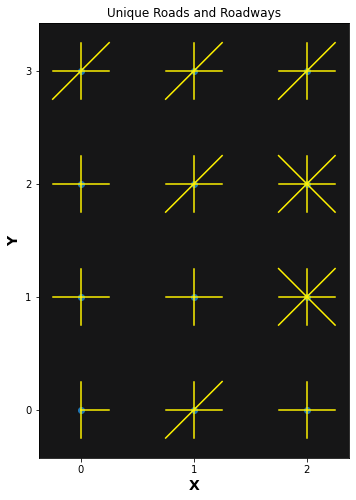

In [13]:
# creating a direction dictionary

dir_dict = {'EB': (1, 0), 'NB': (0, 1), 'SB': (0, -1), 'WB': (-1, 0), 'NE': (1, 1), 'SE': (-1, 1), 'NW': (1, -1), 'SW': (-1, -1)}

# setting plot background

plt.rcParams['axes.facecolor'] = '#161617' # blue

# plotting image

plt.figure(figsize=(8, 8))
plt.scatter(roadways.x, roadways.y)
plt.gca().set_aspect('equal')

# ploting the unique roadways (points) and the unique roadways with directions (lines)

for _, x, y, d in road_dir.itertuples():
    dx, dy = dir_dict[d]
    dx, dy = dx/4, dy/4
    plt.plot([x, x+dx], [y, y+dy], color='#fff200')

# only integer labels
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) 

plt.xlabel('X', fontsize=14, fontweight = 'bold')
plt.ylabel('Y', fontsize=14, fontweight = 'bold')
plt.title('Unique Roads and Roadways', fontsize=12)
plt.show()

Observations: 
- Knowing that congestion is measured for certain points and directions in space, we could assume the existence of a congestion correlation between two or more roadways, e.g. congestion at (1, 1, westbound) should be correlated with past congestion at (0, 1, ...) or vice-versa.
- However, itsn't clear if we need the geography at all. A simple approach for the competition could be ignoring the geography and creating 65 independent time series. Or doing one-hot encoding the 65 x,y/direction combinations and using them as features.
- Another unclear aspect is how to know if the y axis grows from top to bottom or bottom to top.


#### Time feature

In the training dataset there are **13,059** time values. 
Also, as we know, there are 65 combinations of roadways with directions, so 13,059 * 65 equals to **848,835 examples**  of training data.

 


In [14]:
#converting to time type
train_df["time"] = pd.to_datetime(train_df["time"])

unique_times = train_df.time.unique()
print("Number of unique times in training dataset:", len(unique_times))

Number of unique times in training dataset: 8761


All of `train` timestamps are between 1991-04-01 00:00 and 1991-09-30 11:40. The `test` timestamps cover the half day from 1991-09-30 12:00 through 1991-09-30 23:40, which is a Monday.

In [15]:
# diffence about sequences of timestamps
np.diff(unique_times)

array([1200000000000, 1200000000000, 1200000000000, ..., 1200000000000,
       1200000000000, 1200000000000], dtype='timedelta64[ns]')

The difference between successive training timestamps is almost always 20 minutes. However there are **28 timestamps** that don't follow this same distribuition (listed below).

In [16]:
# from all the unique times, getting all examples which the discrete difference are diferent from 20 min (1200000000000 ns) 

unique_times[1:][np.diff(unique_times) != np.diff(unique_times)[0]]

array(['1991-04-20T19:20:00.000000000', '1991-04-24T06:20:00.000000000',
       '1991-05-04T22:00:00.000000000', '1991-05-18T19:40:00.000000000',
       '1991-05-31T03:20:00.000000000', '1991-06-15T20:40:00.000000000',
       '1991-07-18T20:20:00.000000000', '1991-07-20T19:40:00.000000000'],
      dtype='datetime64[ns]')

In [17]:
# example case: from 1991-09-12 06:20:00 to 1991-09-12 08:20:00

train_df[765795:]

,row_id,time,x,y,direction,congestion


Observations so far:

- There are missing values, and our model will have to deal with a noncontiguous time series. This part is goin to be more discussed in the feature engineering stage.
- As the test set is restricted to one Monday afternoon, so perhaps it won't be necessary train in all days of the week.

#### Congestion Label

Congestion is the dataset label and has **integers** numbers variating between 1 to 100. Because most regression algorithms output float values, we could probably clip and round the regression output. 

ref: https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/301249

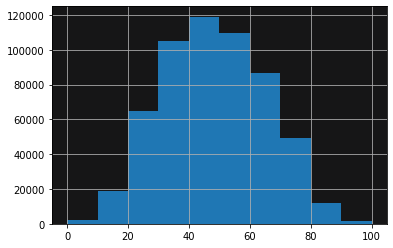

In [18]:
train_df['congestion'].hist()

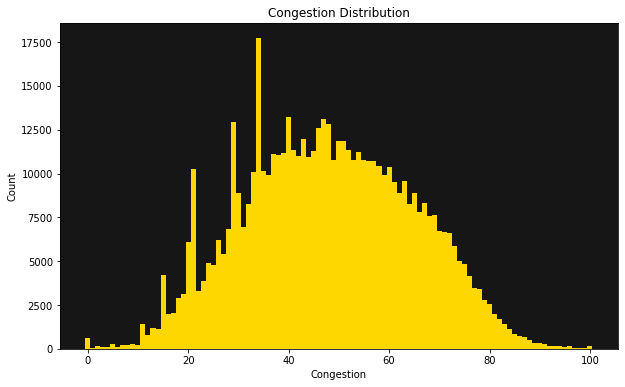

In [19]:
# overall congestion histogram

plt.figure(figsize=(10, 6))
plt.bar(range(101), train_df.congestion.value_counts().sort_index(), width=1,
        color='gold')
plt.ylabel('Count')
plt.xlabel('Congestion')
plt.title("Congestion Distribution")
plt.show()

Because of there are prominent values like 15, 20, 21, 29, 34, it could be a problem for the regressor learn this distribution.


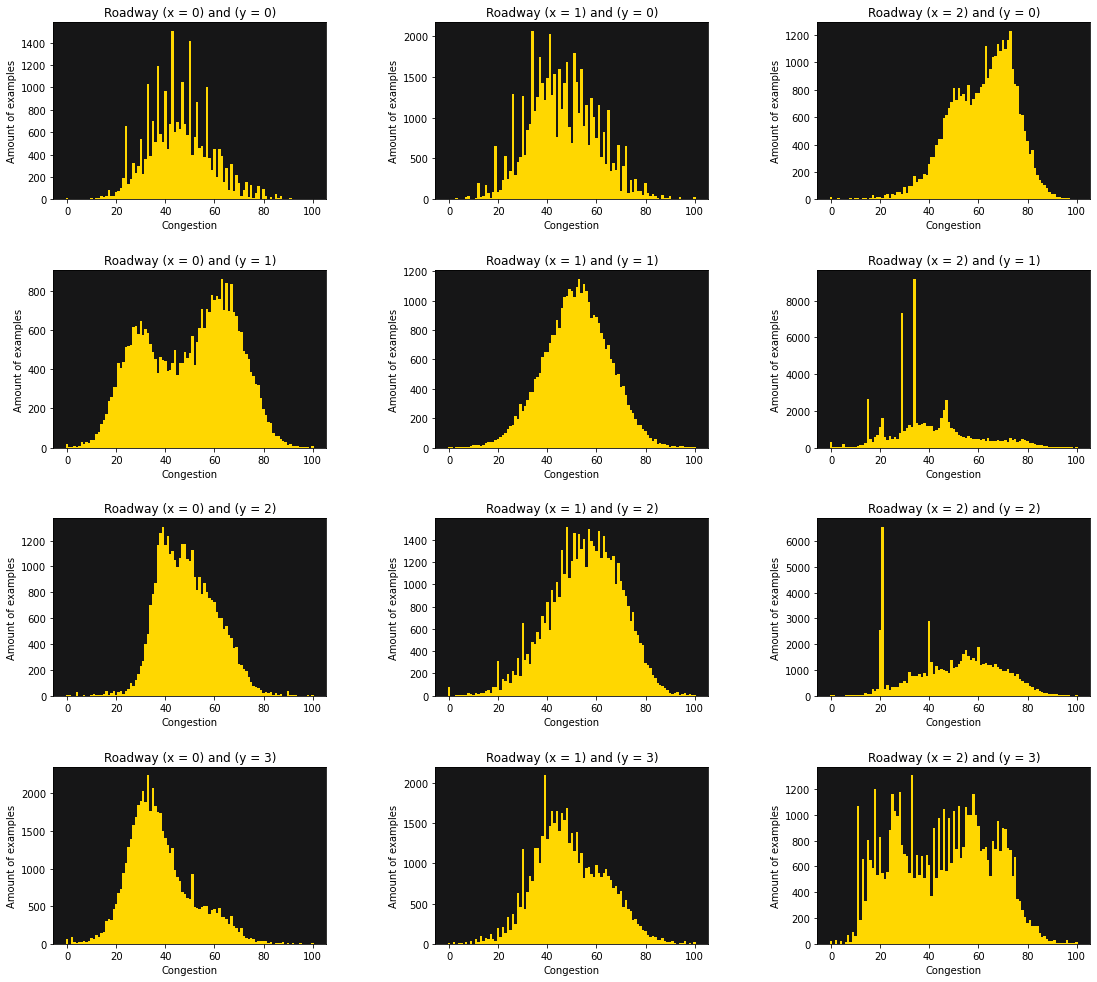

In [20]:

plt.subplots(4, 3, sharex=True, sharey=True, figsize=(18, 16))
#fig, axes = plt.subplots(nrows=4, ncols=3)
for y in range(4):
    for x in range(3):
        #plt.subplot(4, 3, x+1)
        plt.subplot2grid((4,3), (y,x))
        vc = train_df[(train_df.x == x) & (train_df.y == y)].congestion.value_counts().sort_index()
        plt.bar(vc.index, vc, width=1,
                color='gold')
        plt.ylabel('Amount of examples')
        plt.xlabel('Congestion')
        plt.title(f"Roadway (x = {x}) and (y = {y})")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

Notice that congestions like 15, 29 and 34 are a particularity of the roadway with x = 2 and y = 1. Roadway x = 2 and y = 2 seems also a bit imbalanced.

At this point, we could conclude that **a simple linear regressor won't be able to model the data**. We could use a model like decision trees that can make the non-linear separation.

#### Congestion and Time

Space to search and analyze patterns of congestion through days of the week. 

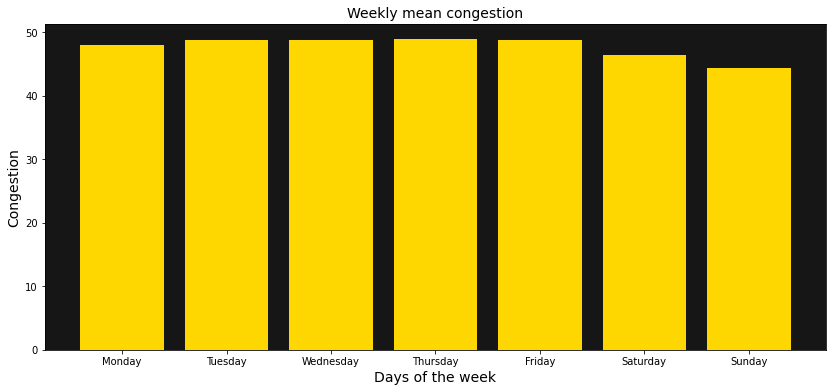

In [21]:
cong_time = train_df.groupby(train_df.time.dt.dayofweek).congestion.mean()
plt.figure(figsize=(14, 6))
plt.title('Weekly mean congestion', fontsize=14)
plt.xlabel('Days of the week', fontsize=14)
plt.ylabel('Congestion', fontsize=14)
plt.bar(cong_time.index, cong_time, color='gold')
plt.xticks(ticks=cong_time.index, labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

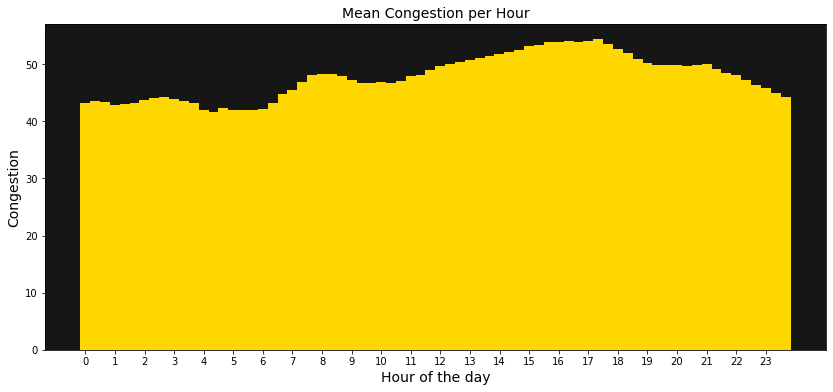

In [22]:
cong_day = train_df.groupby(train_df.time.dt.hour + train_df.time.dt.minute/60).congestion.mean()
plt.figure(figsize=(14, 6))
plt.title('Mean Congestion per Hour', fontsize=14)
plt.bar(cong_day.index, cong_day, color='gold', width=0.34)
plt.xticks(range(24))
plt.xlabel('Hour of the day', fontsize=14)
plt.ylabel('Congestion', fontsize=14)
plt.show()

The graphs show that there is a weekly pattern with low congestion on the weekend and also, a daily pattern with a morning peak and a higher peak in the late afternoon.

#### Morning versus Afternoon

In [23]:
#!pip install matplotlib==3.3.0

TypeError: ignored

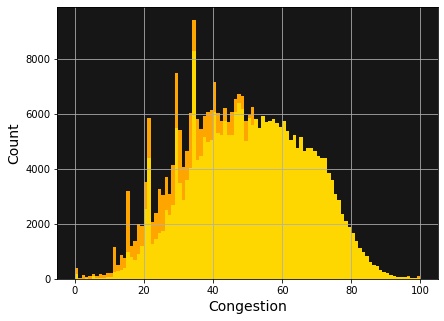

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
train_df[train_df.time.dt.hour<12].congestion.hist(bins=100, color='orange', label='Morning')
train_df[train_df.time.dt.hour>=12].congestion.hist(bins=100, color='gold', label='Afternoon')
plt.xlabel('Congestion', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(labelcolor='linecolor')

plt.subplot(1,2,2)
train_df[train_df.time.dt.hour>=12].congestion.hist(bins=100, color='gold', label='Afternoon')
train_df[train_df.time.dt.hour<12].congestion.hist(bins=100, color='orange', label='Morning')
plt.xlabel('Congestion', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(labelcolor='linecolor')

plt.show()

We also should analyze congestion at the holidays of this period, like Fourth of July and so on. 

TypeError: ignored

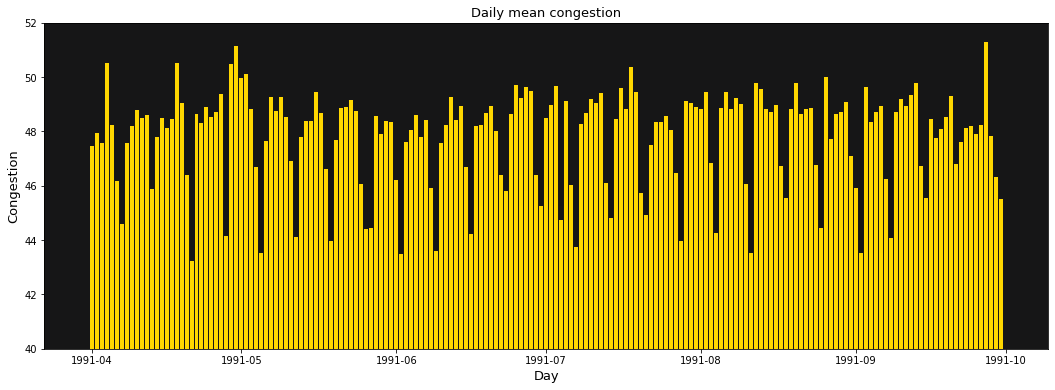

In [25]:
temp = data.groupby(data.time.dt.date).congestion.mean()

plt.figure(figsize=(18, 6))
plt.title('Daily mean congestion', fontsize=13)
plt.xlabel('Day', fontsize=13)
plt.ylabel('Congestion', fontsize=13)
plt.bar(temp.index, temp, color='#ffd700')
plt.ylim(40, 52)

for holiday_name, month, day in [('Memorial Day', 5, 27), ('Fourth of July', 7, 4)]:
    date = datetime.date(1991, month, day)
    plt.annotate(holiday_name,
                 (np.datetime64(date), temp.loc[date]),
                 xytext=(np.datetime64(date), temp.loc[date]-2),
                 arrowprops={'arrowstyle': '-'},
                 weight='bold',
                 color='k',  fontsize=16)
plt.show()

Only Memorial Day it's on the weekend. The 4th of July (which was a Thursday) has meager traffic, and the same occurs with Labor day that happens on a Monday.

Holidays reference: https://www.timeanddate.com/calendar/?year=1991&country=1

Observations:

- Thus, these outliers can be a considerable problem if we want our model to learn this data distribution. A simple approach could be dropping all the holidays before training.
- Overall, there seem to be weeks with high traffic and weeks with low traffic, and there are yet no reasons why this happens.
- A good validation strategy will be important. Because we know that the test dataset is to predict the monday afternoon,perhaps we can use a few Monday afternoons as validation set.

> *to do: covariance matrix.*

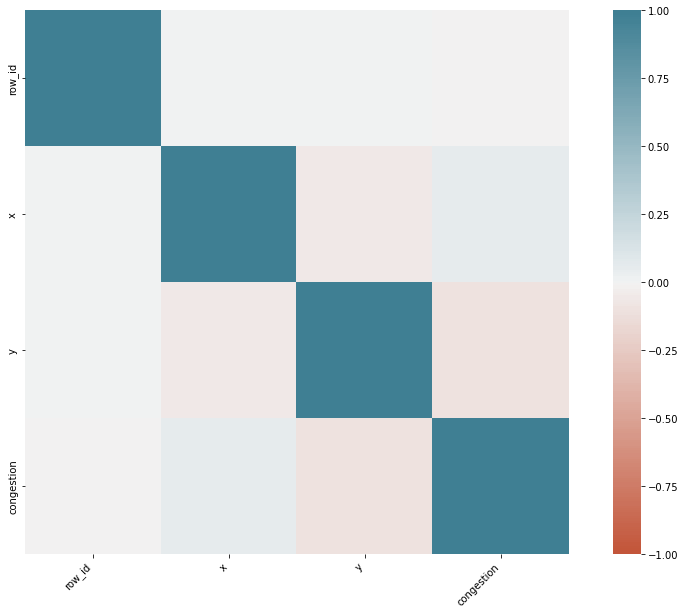

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))

corr = train_df.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

In [27]:
train_df

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...,...
569460,569460,1991-07-31 23:40:00,2,3,NB,64
569461,569461,1991-07-31 23:40:00,2,3,NE,44
569462,569462,1991-07-31 23:40:00,2,3,SB,69
569463,569463,1991-07-31 23:40:00,2,3,SW,16


### Timestamp Imputation

In [28]:
train_df['road'] = train_df['x'].astype(str) + train_df['y'].astype(str) + train_df['direction']
le = LabelEncoder()
train_df['road'] = le.fit_transform(train_df['road'])
train_df

,row_id,time,x,y,direction,congestion,road
0,0,1991-04-01 00:00:00,0,0,EB,70,0
1,1,1991-04-01 00:00:00,0,0,NB,49,1
2,2,1991-04-01 00:00:00,0,0,SB,24,2
3,3,1991-04-01 00:00:00,0,1,EB,18,3
4,4,1991-04-01 00:00:00,0,1,NB,60,4
...,...,...,...,...,...,...,...
569460,569460,1991-07-31 23:40:00,2,3,NB,64,60
569461,569461,1991-07-31 23:40:00,2,3,NE,44,61
569462,569462,1991-07-31 23:40:00,2,3,SB,69,62
569463,569463,1991-07-31 23:40:00,2,3,SW,16,63


In [29]:
# creating the complete timestamp 

time_idx = pd.date_range("1991-04-01 00:00:00","1991-09-30 11:40:00", name="time", freq="20min")
time_idx

DatetimeIndex(['1991-04-01 00:00:00', '1991-04-01 00:20:00',
               '1991-04-01 00:40:00', '1991-04-01 01:00:00',
               '1991-04-01 01:20:00', '1991-04-01 01:40:00',
               '1991-04-01 02:00:00', '1991-04-01 02:20:00',
               '1991-04-01 02:40:00', '1991-04-01 03:00:00',
               ...
               '1991-09-30 08:40:00', '1991-09-30 09:00:00',
               '1991-09-30 09:20:00', '1991-09-30 09:40:00',
               '1991-09-30 10:00:00', '1991-09-30 10:20:00',
               '1991-09-30 10:40:00', '1991-09-30 11:00:00',
               '1991-09-30 11:20:00', '1991-09-30 11:40:00'],
              dtype='datetime64[ns]', name='time', length=13140, freq='20T')

In [30]:
# creating new data that contains all timestamps to be merge with the actual data
new_data = pd.DataFrame(columns=['time'])
new_data["time"] = pd.to_datetime(new_data["time"])

new_data["time"] = time_idx
new_data= new_data.loc[new_data.index.repeat(65)] # reapeat 65 cuz are 65 roads

roads = pd.DataFrame(columns=['road'])
for x in range(65):
    roads.loc[x] = [x]
roads = pd.concat([roads]*13140, ignore_index=True) # reapeat 13140 cuz are 13140 timestamps

# adding roads to the new data
new_data['road'] = roads['road'].values

new_data

,time,road
0,1991-04-01 00:00:00,0
0,1991-04-01 00:00:00,1
0,1991-04-01 00:00:00,2
0,1991-04-01 00:00:00,3
0,1991-04-01 00:00:00,4
...,...,...
13139,1991-09-30 11:40:00,60
13139,1991-09-30 11:40:00,61
13139,1991-09-30 11:40:00,62
13139,1991-09-30 11:40:00,63


In [31]:
new_data = new_data.reset_index()
# 570959

In [32]:
new_train = new_data[0:570960]
new_train = new_train.drop(['index'], axis=1)
new_train

,time,road
0,1991-04-01 00:00:00,0
1,1991-04-01 00:00:00,1
2,1991-04-01 00:00:00,2
3,1991-04-01 00:00:00,3
4,1991-04-01 00:00:00,4
...,...,...
570955,1991-07-31 23:40:00,60
570956,1991-07-31 23:40:00,61
570957,1991-07-31 23:40:00,62
570958,1991-07-31 23:40:00,63


In [33]:
# merging the new_train to the original train dataset(match congestion etc)
merged_left = pd.merge(left=new_train, right=train_df, how='left', left_on=['time', 'road'], right_on=['time', 'road'])

merged_left

,time,road,row_id,x,y,direction,congestion
0,1991-04-01 00:00:00,0,0.0,0.0,0.0,EB,70.0
1,1991-04-01 00:00:00,1,1.0,0.0,0.0,NB,49.0
2,1991-04-01 00:00:00,2,2.0,0.0,0.0,SB,24.0
3,1991-04-01 00:00:00,3,3.0,0.0,1.0,EB,18.0
4,1991-04-01 00:00:00,4,4.0,0.0,1.0,NB,60.0
...,...,...,...,...,...,...,...
570955,1991-07-31 23:40:00,60,569460.0,2.0,3.0,NB,64.0
570956,1991-07-31 23:40:00,61,569461.0,2.0,3.0,NE,44.0
570957,1991-07-31 23:40:00,62,569462.0,2.0,3.0,SB,69.0
570958,1991-07-31 23:40:00,63,569463.0,2.0,3.0,SW,16.0


In [34]:
# checking the Nans samples 
merged_left.isna().sum()

time             0
road             0
row_id        1495
x             1495
y             1495
direction     1495
congestion    1495
dtype: int64

In [35]:
# converting time to int so the imputerKNN works
merged_left['time']=merged_left.time.astype('int64')

# converting the direction to numerical so the imputerKNN works
le = LabelEncoder()
merged_left['direction'] = le.fit_transform(merged_left['direction'])

# imputing missing data
imputer = KNNImputer(n_neighbors=5)
final_train = pd.DataFrame(imputer.fit_transform(merged_left),columns = merged_left.columns)

# converting time to datetime type
final_train["time"] = pd.to_datetime(final_train["time"])

final_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


,time,road,row_id,x,y,direction,congestion
0,1991-04-01 00:00:00,0.0,0.0,0.0,0.0,0.0,70.0
1,1991-04-01 00:00:00,1.0,1.0,0.0,0.0,1.0,49.0
2,1991-04-01 00:00:00,2.0,2.0,0.0,0.0,4.0,24.0
3,1991-04-01 00:00:00,3.0,3.0,0.0,1.0,0.0,18.0
4,1991-04-01 00:00:00,4.0,4.0,0.0,1.0,1.0,60.0
...,...,...,...,...,...,...,...
570955,1991-07-31 23:40:00,60.0,569460.0,2.0,3.0,1.0,64.0
570956,1991-07-31 23:40:00,61.0,569461.0,2.0,3.0,2.0,44.0
570957,1991-07-31 23:40:00,62.0,569462.0,2.0,3.0,4.0,69.0
570958,1991-07-31 23:40:00,63.0,569463.0,2.0,3.0,6.0,16.0


In [36]:
final_train.isna().sum()

time          0
road          0
row_id        0
x             0
y             0
direction     0
congestion    0
dtype: int64

In [37]:
final_train = final_train.drop(['road'], axis=1)

In [38]:
train_df = final_train.copy()

### Feature Engineering 

In [39]:
# add or delete columns/attributes to the train and test datasets

def feature_eng(dataset, test=False):

    
    # adding new columns:
    # year, hour, week, minute, month, day of de week, day of year, is weekend, yesterday,
    # is_afternoon, is_month_start, is_month_end and moment

    # converting time column into datatime type
    dataset["time"] = pd.to_datetime(dataset["time"])
    
    # adding the new time columns
    dataset['hour'] = dataset.time.dt.hour
    dataset['week'] = dataset.time.dt.isocalendar().week
    dataset['minute'] = dataset.time.dt.minute
    dataset['month'] = dataset.time.dt.month
    dataset['day_of_week'] = dataset.time.dt.day_name()
    dataset['is_afternoon'] = (dataset['time'].dt.hour > 12).astype('int')
    dataset['day_of_year'] = dataset.time.dt.dayofyear
    dataset['is_weekend'] = (dataset.time.dt.dayofweek >= 5).astype("int")
    dataset['is_month_start'] = dataset.time.dt.is_month_start.astype('int')
    dataset['is_month_end'] = dataset.time.dt.is_month_end.astype('int')
    # number of 20' period in a day
    dataset['moment']  = dataset['time'].dt.hour * 3 + dataset['time'].dt.minute // 20 
    #dataset['yesterday'] = dataset.groupby(['x','y','direction','hour','minute'])['congestion'].transform(lambda x: x.shift(1))

    
    # is_holiday feature -> 1 if is holiday, 0 if is not    
    #make_date(dataset, 'time')
    us_holidays = []
    for x in holidays.UnitedStates(years=1991).items():
        us_holidays.append(str(x[0]))
    
    dataset['is_holiday'] = [1 if str(val).split()[0] in us_holidays else 0 for  val in dataset['time'].dt.date]

    # transformation to get unique roadways with directions
    # x, y, direction -> road

    
    dataset['road'] = dataset['x'].astype(str) + dataset['y'].astype(str) + dataset['direction'].astype(str)
    
    # label encoding (it could be one-hot encoding tho)
    le = LabelEncoder()
    dataset['road'] = le.fit_transform(dataset['road'])

    
    # dropping the redundant columns
    dataset = dataset.drop(['x', 'y', 'direction'], axis=1)
    #dataset = dataset.set_index('time')

    # creating congestion min, max and median columns group by 'road', 'weekday', 'hour', 'minute'

    # min
    mins = pd.DataFrame(dataset.groupby(['road', 'day_of_week', 'moment']).congestion.min().astype(int)).reset_index()
    mins = mins.rename(columns={'congestion':'min'})
    dataset = dataset.merge(mins, on=['road', 'day_of_week', 'moment'], how='left')

    # max
    maxs = pd.DataFrame(dataset.groupby(['road', 'day_of_week', 'moment']).congestion.max().astype(int)).reset_index()
    maxs = maxs.rename(columns={'congestion':'max'})
    dataset = dataset.merge(maxs, on=['road', 'day_of_week', 'moment'], how='left')

    # median
    medians = pd.DataFrame(dataset.groupby(['road', 'day_of_week', 'moment']).congestion.median().astype(int)).reset_index()
    medians = medians.rename(columns={'congestion':'median'})
    dataset = dataset.merge(medians, on=['road', 'day_of_week', 'moment'], how='left')

    # mean
    means = pd.DataFrame(dataset.groupby(['road', 'day_of_week', 'moment']).congestion.mean().astype(int)).reset_index()
    means = means.rename(columns={'congestion':'mean'})
    dataset = dataset.merge(means, on=['road', 'day_of_week', 'moment'], how='left')


    return dataset

In [40]:
train_df = feature_eng(train_df)

In [41]:
train_df.head()

,time,row_id,congestion,hour,week,minute,month,day_of_week,is_afternoon,day_of_year,is_weekend,is_month_start,is_month_end,moment,is_holiday,road,min,max,median,mean
0,1991-04-01,0.0,70.0,0,14,0,4,Monday,0,91,0,1,0,0,0,0,32,80,36,40
1,1991-04-01,1.0,49.0,0,14,0,4,Monday,0,91,0,1,0,0,0,1,16,49,30,30
2,1991-04-01,2.0,24.0,0,14,0,4,Monday,0,91,0,1,0,0,0,2,24,91,24,34
3,1991-04-01,3.0,18.0,0,14,0,4,Monday,0,91,0,1,0,0,0,3,6,26,15,15
4,1991-04-01,4.0,60.0,0,14,0,4,Monday,0,91,0,1,0,0,0,4,52,72,62,61


In [42]:
valid_df = feature_eng(valid_df)

In [43]:
test_df = feature_eng(test_df, True)

In [44]:
# testing holiday
test_df[test_df['row_id']==720000]

,row_id,time,congestion,hour,week,minute,month,day_of_week,is_afternoon,day_of_year,is_weekend,is_month_start,is_month_end,moment,is_holiday,road,min,max,median,mean
6885,720000,1991-09-02 11:00:00,57,11,36,0,9,Monday,0,245,0,0,0,33,1,60,50,58,52,53


In [45]:
# dropping id from dataset
test_df = test_df.drop(['row_id'], axis=1)
train_df = train_df.drop(['row_id'], axis=1)
valid_df = valid_df.drop(['row_id'], axis=1)

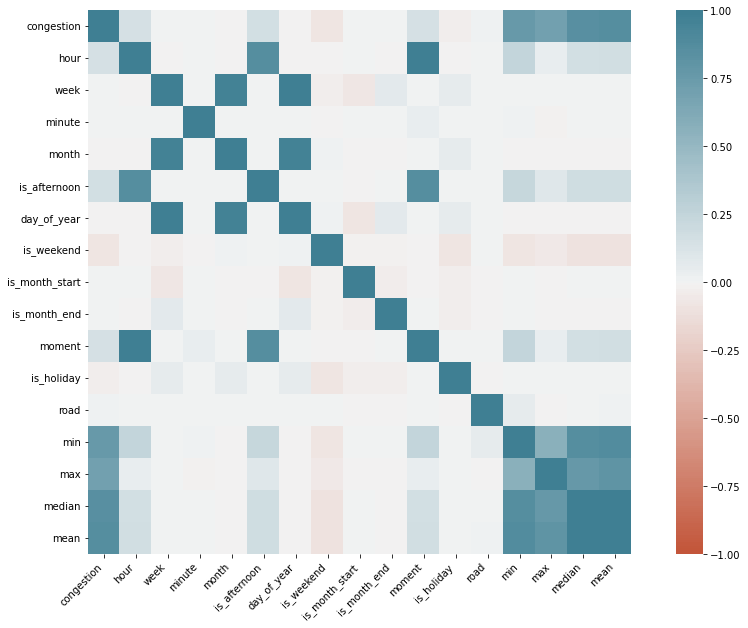

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))

corr = train_df.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

#### Final Features
- row_id:train (0 to 848834), test(848835 to 851174)
- time: date and time
- x:(0,1,2)
- y:(0,1,2,3)
- direction: EB(East bound),NB(North Bound),SB(South Bound),WB(West Bound),NE(Northeast Bound),SW(Southwest Bound),NW(Northwest Bound),SE(Southeast Bound)
- congestion: (0 to 101)
- is_holiday: (0 or 1)
- month: (4 to 9)
- week:(14 to 40)
- day:(91: 273)
- hour: (0 to 23)
- minute:(0,20,40)
- dayofweek(0 to 6)
- weekday:(Mon = 0,Fri = 4)
- is_month_start: if the day is start of the month or not(bool)
- is_month_end: if the day is end of the month or not(bool)
- is_weekend: if the day is the weekend or not(bool, Sat = 1, Sun = 1, Mon to Fri = 0)
- is_afternoon: if time is afternoon or not(bool)
- mean, median, max and min congestion(0 to 100)
- road: x + y + Direction

## Modelling

### Validation Data

#### Slicing X and Y from validation and train datasets

In [47]:
# split into train and test

# this use all Monday-Wednesday afternoons in August and September for validation

# converting time column into datatime type
#train_original["time"] = pd.to_datetime(train_original["time"])

val_idx = ((train_df.time.dt.month == 8)).values

train_idx = ~val_idx

y_test = test_df.pop("congestion")

features = list(test_df.columns)

X_train, X_valid = train_df[features], valid_df[features]

y_train, y_valid = train_df.pop("congestion"), valid_df.pop("congestion")

In [48]:
X_test = test_df

In [49]:
# adjusting the train data: doing label encoding

In [50]:
le = LabelEncoder()
X_train['day_of_week'] = le.fit_transform(X_train['day_of_week'])
X_valid['day_of_week'] = le.fit_transform(X_valid['day_of_week'])
X_test['day_of_week'] = le.fit_transform(X_test['day_of_week'])

In [51]:
X_train['week'] = X_train['week'].astype('int64')
X_valid['week'] = X_valid['week'].astype('int64')
X_test['week'] = X_test['week'].astype('int64')

In [52]:
X_train = X_train.drop(['time'], axis=1)
X_valid = X_valid.drop(['time'], axis=1)
X_test = X_test.drop(['time'], axis=1)

In [53]:
X_train.head()

,hour,week,minute,month,day_of_week,is_afternoon,day_of_year,is_weekend,is_month_start,is_month_end,moment,is_holiday,road,min,max,median,mean
0,0,14,0,4,1,0,91,0,1,0,0,0,0,32,80,36,40
1,0,14,0,4,1,0,91,0,1,0,0,0,1,16,49,30,30
2,0,14,0,4,1,0,91,0,1,0,0,0,2,24,91,24,34
3,0,14,0,4,1,0,91,0,1,0,0,0,3,6,26,15,15
4,0,14,0,4,1,0,91,0,1,0,0,0,4,52,72,62,61


#### 1. Random Forest

In [277]:
rf = RandomForestRegressor(n_estimators=0, max_samples=0.03,
                             n_jobs=-1, random_state=random.randint(0,1000))


estimators_list, mae_list = [], []
n_estimators = 4
initialized = False
while n_estimators < 256:
    n_estimators *= 4
    
    rf.set_params(n_estimators=n_estimators,
                    warm_start=initialized)
    
    rf.fit(X_train, y_train)
    
    initialized = True

    # Compute the (intermediate) validation score
    y_va_pred = rf.predict(X_valid)
    
    estimators_list.append(rf.get_params()['n_estimators'])
    mae_list.append(mean_absolute_error(y_valid, y_va_pred))
    print(f"{estimators_list[-1]:4} estimators:   "
          f"Validation MAE = {mae_list[-1]:.5f}")

  16 estimators:   Validation MAE = 5.64497
  64 estimators:   Validation MAE = 5.43578
 256 estimators:   Validation MAE = 5.39239


#### 2. XgBoost

In [278]:
#!pip install xgboost

In [280]:
xg = xgb.XGBRegressor(n_estimators=0,
                             n_jobs=-1, random_state=random.randint(0,1000))


estimators_list, mae_list = [], []
n_estimators = 4
initialized = False
while n_estimators < 256:
    n_estimators *= 4
    
    xg.set_params(n_estimators=n_estimators)
    
    xg.fit(X_train, y_train)
    
    initialized = True

    # Compute the (intermediate) validation score
    y_va_pred = xg.predict(X_valid)
    
    estimators_list.append(xg.get_params()['n_estimators'])
    mae_list.append(mean_absolute_error(y_valid, y_va_pred))
    print(f"{estimators_list[-1]:4} estimators:   "
          f"Validation MAE = {mae_list[-1]:.5f}")

[22:20:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  16 estimators:   Validation MAE = 9.84638
[22:20:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  64 estimators:   Validation MAE = 5.24297
[22:21:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 256 estimators:   Validation MAE = 5.29875


#### 3. HistGradientBoostingRegressor 

In [281]:



hg = HistGradientBoostingRegressor( max_iter=10875, max_leaf_nodes=176, max_depth=18, min_samples_leaf=49,
                                    random_state=random.randint(0,1000), loss='absolute_error')


hg.fit(X_train, y_train)


# Compute the (intermediate) validation score
y_va_pred = hg.predict(X_valid)

print("Validation MAE: ", mean_absolute_error(y_valid, y_va_pred))


Validation MAE:  5.151566280154633


#### 4. MLP Regressor 

In [282]:


model1 = MLPRegressor(random_state=31, max_iter=300, hidden_layer_sizes=(20, 14, 5))
model1.fit(X_train, y_train)

model2 = MLPRegressor(random_state=31, max_iter=300, hidden_layer_sizes=(8, 6, 4))
model2.fit(X_train, y_train)

model3 = MLPRegressor(random_state=31, max_iter=300, hidden_layer_sizes=(1, 1))
model3.fit(X_train, y_train)


# Compute the (intermediate) validation score
pred_1 = model1.predict(X_valid)
pred_2 = model2.predict(X_valid)
pred_3 = model3.predict(X_valid)

print("Validation MAE - Model 1: ", mean_absolute_error(y_valid, pred_1))
print("Validation MAE - Model 2: ", mean_absolute_error(y_valid, pred_2))
print("Validation MAE - Model 3: ", mean_absolute_error(y_valid, pred_3))

Validation MAE - Model 1:  5.3932013032019634
Validation MAE - Model 2:  5.235413697499448
Validation MAE - Model 3:  14.017352937037078


#### 5. GradientBoostingRegressor

In [283]:


gb = GradientBoostingRegressor(n_estimators=0, random_state=random.randint(0,1000))


estimators_list, mae_list = [], []
n_estimators = 4
initialized = False
while n_estimators < 256:
    n_estimators *= 4
    
    gb.set_params(n_estimators=n_estimators)
    
    gb.fit(X_train, y_train)
    
    initialized = True

    # Compute the (intermediate) validation score
    y_va_pred = gb.predict(X_valid)
    
    estimators_list.append(gb.get_params()['n_estimators'])
    mae_list.append(mean_absolute_error(y_valid, y_va_pred))
    print(f"{estimators_list[-1]:4} estimators:   "
          f"Validation MAE = {mae_list[-1]:.5f}")

  16 estimators:   Validation MAE = 5.99060
  64 estimators:   Validation MAE = 5.24651
 256 estimators:   Validation MAE = 5.27031


### Grid Search

In [284]:
# grid search comentado para não executar todas as vezes.
'''
from sklearn.model_selection import GridSearchCV

hg = HistGradientBoostingRegressor()
parameters = {  'learning_rate': [.01, .9],
                'max_iter': [1000, 1200],
                'min_samples_leaf': [15, 20],
                'max_depth': [None, 10, 20],
                'l2_regularization': [0.1, 0.001, 0.0001]}

hg_grid = GridSearchCV(hg,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

hg_grid.fit(X_train, y_train)

print(hg_grid.best_score_)
print(hg_grid.best_params_)

'''

"\nfrom sklearn.model_selection import GridSearchCV\n\nhg = HistGradientBoostingRegressor()\nparameters = {  'learning_rate': [.01, .9],\n                'max_iter': [1000, 1200],\n                'min_samples_leaf': [15, 20],\n                'max_depth': [None, 10, 20],\n                'l2_regularization': [0.1, 0.001, 0.0001]}\n\nhg_grid = GridSearchCV(hg,\n                        parameters,\n                        cv = 2,\n                        n_jobs = 5,\n                        verbose=True)\n\nhg_grid.fit(X_train, y_train)\n\nprint(hg_grid.best_score_)\nprint(hg_grid.best_params_)\n\n"

Grid search result:

```
Fitting 2 folds for each of 72 candidates, totalling 144 fits
0.7386887458478943
{'l2_regularization': 0.001, 'learning_rate': 0.01, 'max_depth': 20, 'max_iter': 1000, 'min_samples_leaf': 20}
``` 

### Feature Importance

In [285]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_train, y_train)
mi_scores = pd.Series(mi_scores, name="MI_score", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)
df_mi_scores = pd.DataFrame(mi_scores).reset_index().rename(columns={'index':'feature'})
df_mi_scores

,feature,MI_score
0,median,0.635129
1,mean,0.630467
2,min,0.493863
3,max,0.447115
4,road,0.076087
5,hour,0.035557
6,moment,0.033456
7,is_afternoon,0.015659
8,is_weekend,0.004291
9,month,0.003826


<AxesSubplot:xlabel='MI_score', ylabel='feature'>

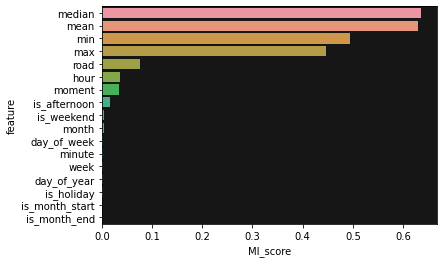

In [286]:
sns.barplot(y=df_mi_scores['feature'], x=df_mi_scores['MI_score'])

In [287]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(8,4))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#df_data = load_data()
#pp.ProfileReport(df_data)

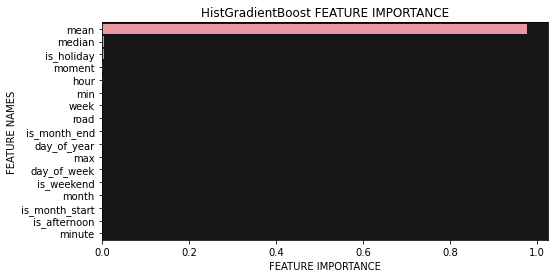

In [291]:
plot_feature_importance(xg.feature_importances_,X_valid.columns,'HistGradientBoost')

## Results

In [64]:
X_train_final = pd.concat([X_train, X_valid])
y_train_final = pd.concat([y_train, y_valid])

### Models Setup: Testing (run only once)

In [68]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MLA = [
       HistGradientBoostingRegressor(random_state=random.randint(0,1000), l2_regularization = 0.001, learning_rate = 0.01, max_depth = 20, max_iter = 1000, min_samples_leaf = 20),
       xgb.XGBRegressor(n_estimators=64, n_jobs=-1, random_state=random.randint(0,1000)),
       RandomForestRegressor(n_estimators=256, max_samples=0.03, n_jobs=-1, random_state=random.randint(0,1000)),
       GradientBoostingRegressor(n_estimators=64, random_state=random.randint(0,1000)),
       MLPRegressor(random_state=random.randint(0,1000), max_iter=300, hidden_layer_sizes=(8, 6, 4))
]

row_index = 0
MLA_compare = pd.DataFrame()

model_names = []
r2_scores = []
y_preds = []

for model in MLA:
    model.fit(X_train_final, y_train_final)

    y_pred = model.predict(X_test)

    model_r2_score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    MLA_name = model.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'R2 Score'] = model_r2_score
    MLA_compare.loc[row_index, 'MSE'] = mse
    MLA_compare.loc[row_index, 'MAE'] = mae

    row_index+=1

[00:54:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [69]:
MLA_compare

,MLA Name,R2 Score,MSE,MAE
0,HistGradientBoostingRegressor,0.786787,59.156735,5.381761
1,XGBRegressor,0.787032,59.088799,5.370554
2,RandomForestRegressor,0.784733,59.726557,5.487457
3,GradientBoostingRegressor,0.787082,59.074986,5.373932
4,MLPRegressor,0.785955,59.387504,5.372227


### Preds Distribution

In [ ]:
# todo list:
# 
# pre-processing part

    # correlation matrix ✔️
    # timestamps imputation (using KNN) ✔️
    # median, mean features ✔️
    # is_holiday feature ✔️
    # lag features

# classification part

    # pipeline with different models ✔️
    # training results with a lots of features, few features and no feature engineering.
    # clipping congestion results
    # divide all train data into train, valid and test ✔️
    # Preds Distribution (test pred and test y)

# extra
    
    # Cross validation with time series
    # Permutation Importance ref: https://www.kaggle.com/code/dansbecker/permutation-importance/tutorial
    # Mutual Information ref: https://www.kaggle.com/code/ryanholbrook/mutual-information/tutorial
    # Cyclical Features by https://www.kaggle.com/code/inversion/tps-mar-22-cyclical-features/notebook 


In [ ]:
# anotações da aula de dúvidas

# fazer baseline sem feature eng

#[10:40, 06/04/2022] Monimon: treinar um modelo para estimar um atributo
#[10:40, 06/04/2022] Monimon: knn k=3
#[10:43, 06/04/2022] Monimon: ou k=5
#[10:45, 06/04/2022] Monimon: analisar erros por dias, semanas
#[10:45, 06/04/2022] Monimon: erro geral dos 30 dias
#[10:46, 06/04/2022] Monimon: dias uteis ou finais de semana
#[10:52, 06/04/2022] Monimon: falar sobre imputação. qual o k no knn, dsitribuição do dataset
#[10:54, 06/04/2022] Monimon: configurações dos experimentos
#[10:55, 06/04/2022] Monimon: falar de versões de python, das libs
#[10:55, 06/04/2022] Monimon: skitlearn
#[11:00, 06/04/2022] Monimon: separar os outliers em treino e teste
#[11:00, 06/04/2022] Monimon: discutir os outliers
#[11:00, 06/04/2022] Monimon: tal turno, nós observamos uma diferença muito grande
#[11:02, 06/04/2022] Monimon: botar formula de MSE

In [ ]:
'''

#### utils ####

# concat/split train and test datasets

all_df = pd.concat([train_df, test_df])

all_df = feature_eng(all_df)

train_df = all_df[:len(train_df)]
test_df = all_df[-len(test_df):]


# Plot the distribution of the test predictions
# compared to the other Monday afternoons

import matplotlib.pyplot as plt

add_trend(train, trend_train_dict, 'congestion')
plt.figure(figsize=(16,3))
plt.hist(train.congestion[((train.time.dt.weekday == 0) &
                           (train.time.dt.hour >= 12)).values],
         bins=np.linspace(-0.5, 100.5, 102),
         density=True, label='Train',
         color='b')
plt.hist(sub['congestion'], np.linspace(-0.5, 100.5, 102),
         density=True, rwidth=0.5, label='Test predictions',
         color='r')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('Congestion on Monday afternoons')
plt.legend()
plt.show()




'''